In [1]:
import pandas as pd
from sklearn import datasets
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
#Load train data 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
#Load test data 
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
example=enumerate(train_loader)
batch_index,(example_data,example_target)=next(example)

In [5]:
example_data.shape

torch.Size([64, 1, 28, 28])

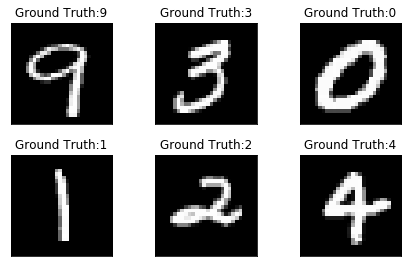

In [6]:

#Visualize the data 
fig=plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray',interpolation='none')
    plt.title("Ground Truth:{}".format(example_target[i]))
    plt.xticks([])
    plt.yticks([])
    fig

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,kernel_size=5)
        self.conv2=nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop=nn.Dropout2d()
        self.fc1=nn.Linear(320,50)
        self.fc2=nn.Linear(50,10)
    def forward(self,x): 
        x=F.relu(F.max_pool2d(self.conv1(x),2))
        x=F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x=x.view(-1,320)
        x=F.relu(self.fc1(x))
        x=F.dropout(x,training=self.training)
        x=self.fc2(x)
        return F.log_softmax(x)
        

In [8]:
network=Net()
optimizer=optim.SGD(network.parameters(),lr=learning_rate,momentum=momentum)#stochastic optimizer

In [9]:
train_losses=[]
test_losses=[]
train_counter=[]
test_counter=[i*len(train_loader.dataset) for i in range(n_epochs+1)]

In [10]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network.state_dict(), './model.pth')
        torch.save(optimizer.state_dict(), './optimizer.pth')

In [29]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_counter.append((data*1000) + ((data-1)*len(test_loader.dataset)))
    torch.save(network.state_dict(), './model.pth')
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return correct

In [30]:
test()
for epoch in range(1,n_epochs+1):
    train(epoch)
    a=test()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/home/aims/.local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0577, Accuracy: 9832/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.163815
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.154027
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.229586
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.170768
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.179560
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.153753
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.086534
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.068130
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.133579
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.156082
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.189213
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.302795
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.203012
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.294490
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.105945
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.229359
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.209955
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.189319
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.203950
Train Epoch: 1 [12160

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.200701
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.046663
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.103039
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.261036
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.128040
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.080902
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.160161
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.146352
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.150399
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.189471
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.180953
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.167651
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.336338
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.142660
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.449889
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.056707
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.063162
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.085456
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.114843
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.139501
